In [1]:
from pathlib import Path

from scipy.optimize import curve_fit
from matplotlib import ticker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


Bad key datapath in file /casa/joha/.config/matplotlib/matplotlibrc, line 65 ('datapath : /utp/joha/.config/matplotlib/data')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution


In [13]:
datadir = Path("../data/fba")
work = "larp1"

fname = {
    "pabpc1": "200512_FBA_PABPC1_Rep1_Rep2_Rep3.csv",
    "larp1": "200613_FBA_LARP1_Rep1_Rep2_Rep3.csv",
}[work]
inpfpath = datadir/fname
data = pd.read_csv(inpfpath, sep=',', encoding='utf-8')
data.head(3)

,LARP1,A0,A25,A50,Replicate
0,0.010,-0.004617,0.000273,0.001797,Rep1
1,0.025,-0.001664,0.009007,0.003807,Rep1
2,0.050,0.005909,0.005907,0.005455,Rep1


In [14]:
# Summarize the data to get the fitted line
groupby_colidx = 0
average = data.groupby(data.columns[groupby_colidx]).agg(np.mean)

In [15]:
def hill_equation(x, top, bottom, ec50, nH):
    return bottom + (top - bottom) * x**nH / (ec50**nH + x**nH)

In [16]:
def get_params(x:np.ndarray, y:np.ndarray):
    global hill_equation
    
    ymin, ymax = y.min(), y.max()

    h = abs(ymax - ymin)
    params_initial = [ymax, ymin, 0.5 * (x[-1] - x[0]) - x[0], 1] 
    params_bounds = (
        [ymax - 0.5 * h, ymin - 0.5 * h, 0.1 * x[0], 0.01], 
        [ymax + 0.5 * h, ymin + 0.5 * h, 10 * x[-1], 100],
    )

    popt, _ = curve_fit(hill_equation, x, y, p0=params_initial, bounds=params_bounds)
    return list(popt)

/casa/joha/anaconda3/envs/polya/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


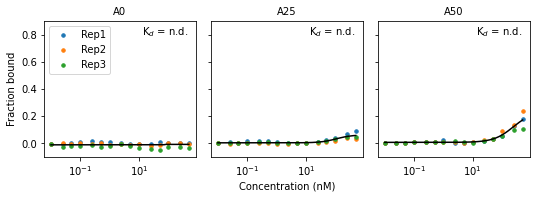

In [17]:
savefig = True

n_cols = len(average.columns)
fig, axes = plt.subplots(1, n_cols,
                         sharex=True, sharey=True, figsize=(8.7,2.5), 
                         gridspec_kw={'hspace':0.1, 'wspace':0.1})

x = np.asarray(average.index)
x_fit = np.linspace(x[0], x[-1], 10000)
for cidx in range(n_cols):
    y = average.iloc[:, cidx]
    params = get_params(x, y)
    y_fit = hill_equation(x_fit, *params)
    
    ax = axes[cidx]
    
    k_ds = []
    for rep, gr in data.groupby('Replicate'):
        x_s = np.asarray(gr.iloc[:, 0])
        y_s = np.asarray(gr.iloc[:, cidx+1])
        ax.scatter(x_s, y_s, label=rep, s=12)

        k_ds.append(get_params(x_s, y_s)[2])
    
    ax.plot(x_fit, y_fit, c="k")
        
    ax.set_title(average.columns[cidx], fontsize='medium')
    
    if y.max() > 0.5:
        k_ds = np.array(k_ds)
        k_d_est = k_ds.mean()
        k_d_err = k_ds.std()
        k_d_disp = rf"K$_d$ = {k_d_est:.2f} $\pm$ {k_d_err:.2f} nM"
    else:
        k_d_disp = r"K$_d$ = n.d."
    ax.text(0.95, 0.9, k_d_disp, transform=ax.transAxes, ha='right')

    
axes[0].set_ylabel("Fraction bound")
axes[0].legend(loc="upper left")
axes[1].set_xlabel("Concentration (nM)")
    
plt.xscale("log")
plt.ylim([-0.1,0.9])

if savefig is True:
    outfigpath = f"../plots/fba_{work}.pdf"
    plt.savefig(outfigpath, bbox_inches="tight")
    
plt.show()